<h1>Building a movie content based recommender using tf-idf</h1>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations


ratings = pd.read_csv('data/Content_based_recommenders/ratings.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'movie_id', 'rating'])
users = pd.read_csv('data/Content_based_recommenders/users.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])
movies = pd.read_csv('data/Content_based_recommenders/movies.csv', sep='\t', encoding='latin-1', usecols=['movie_id', 'title', 'genres'])

In [1]:
import matplotlib as mpl
import seaborn as sb
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
mpl.rcParams['figure.figsize'] = [10,5]

# EDA

In [11]:
ratings.shape

(1000209, 3)

In [12]:
ratings.sample(5)

,user_id,movie_id,rating
83783,550,1274,5
473198,2909,3208,1
246259,1489,2827,1
71278,479,3098,5
694658,4161,1597,1


In [13]:
ratings.groupby('user_id').count().mean()


movie_id    165.597517
rating      165.597517
dtype: float64

A movies dataset:

In [14]:
movies.sample(5)

,movie_id,title,genres
10,11,"American President, The (1995)",Comedy|Drama|Romance
339,343,"Baby-Sitters Club, The (1995)",Children's
3462,3531,All the Vermeers in New York (1990),Comedy|Drama|Romance
3115,3184,Montana (1998),Action|Comedy|Crime|Drama
1778,1847,Ratchet (1996),Drama|Thriller


Having both a `movie_id` , `title` and a string with all genres separated bythe character `|` 

And the users dataset, with basic information about the user:

In [15]:
users.head()

,user_id,gender,zipcode,age_desc,occ_desc
0,1,F,48067,Under 18,K-12 student
1,2,M,70072,56+,self-employed
2,3,M,55117,25-34,scientist
3,4,M,02460,45-49,executive/managerial
4,5,M,55455,25-34,writer


### Data Exploration

As we'll explore in the next section, the genres alone can be used to provide a reasonably good content based recommendation. But before that, we need analyse some important aspects.

### Ratings
Next I want to examine the **rating** further. One important aspect to consider is the distribution of the user ratings:

C:\Users\nomif\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


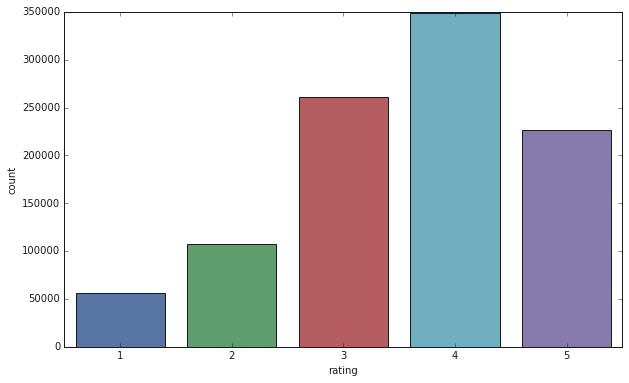

In [17]:
plt.figure(figsize=(10,6))

sb.countplot(ratings['rating'].fillna(ratings['rating'].median()))
plt.show()

* *Which are the most popular movies?*

We can take a weighted score taking into account both the **ratings** and the amount of **views** to answer this question:

In [18]:
def weighted_average_score(df, k=0.8):
    n_views = df.groupby('movie_id', sort=False).movie_id.count()
    ratings = df.groupby('movie_id', sort=False).rating.mean()
    scores = ((1-k)*(n_views/n_views.max()) + 
              k*(ratings/ratings.max())).to_numpy().argsort()[::-1]
    df_deduped = df.groupby('movie_id', sort=False).agg({'title':'first', 
                                                         'genres':'first', 
                                                         'rating':'mean'})
    return df_deduped.assign(views=n_views).iloc[scores]

In [19]:
df = movies.merge(ratings).merge(users)
weighted_average_score(df).head(10)

,title,genres,rating,views
movie_id,,,,
2858,American Beauty (1999),Comedy|Drama,4.317386,3428
260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,4.453694,2991
1198,Raiders of the Lost Ark (1981),Action|Adventure,4.477725,2514
1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,4.292977,2990
318,"Shawshank Redemption, The (1994)",Drama,4.554558,2227
527,Schindler's List (1993),Drama|War,4.510417,2304
858,"Godfather, The (1972)",Action|Crime|Drama,4.524966,2223
2028,Saving Private Ryan (1998),Action|Drama|War,4.337354,2653
2762,"Sixth Sense, The (1999)",Thriller,4.406263,2459


#### Genres

As we'll explore in the next section, the genres alone can be used to provide a reasonably good content based recommendation. But before that, we need analyse some important aspects.

* *Which are the most popular genres?*

This will be a relevant aspect to take into account when building the content based recommender. We want to understand which genres really are relevant when it comes to defining a user's taste. A reasonable assumption is that it is precisely the unpopular genres, that will be more relevant in characterising the user's taste.

movies.genres.str.split('|')The most relevant genres are:

In [20]:
genre_popularity = (movies.genres.str.split('|')
                      .explode()
                      .value_counts()
                      .sort_values(ascending=False))
genre_popularity.head(10)

Drama         1603
Comedy        1200
Action         503
Thriller       492
Romance        471
Horror         343
Adventure      283
Sci-Fi         276
Children's     251
Crime          211
Name: genres, dtype: int64

Or for a more visual representation we could plot a word-cloud with the genres:

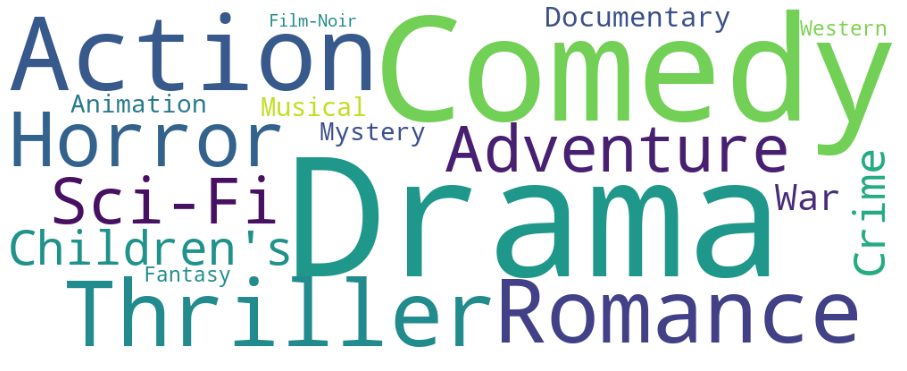

In [21]:
from wordcloud import WordCloud, STOPWORDS
genre_wc = WordCloud(width=1000,height=400, background_color='white')
genre_wc.generate_from_frequencies(genre_popularity.to_dict())

plt.figure(figsize=(16, 8))
plt.imshow(genre_wc, interpolation="bilinear")
plt.axis('off')
plt.show()

As we can see, the most frequent genres are Drama, Comedy and Action, among others. We then have some other genres that are way less frequent such as Western, Fantasy or Sci-Fi. 

As I previously pointed out, these are the genres that we want to give the most importance to when recommending. Why is that?
As an example let's consider new user wants to find movies similar to Interstellar., which is a mixture of Sci-Fi, Drama, Mistery and Adventure. Say now that among the available movies to recommend we have a collection of Drama movies and some other Sci-Fi movies too. Which should we prioritise? In this case, it seems reasonable to assume that the less generic genre, Sci-Fi, will be the most relevant in terms of characterising the movie.

## Building a content based recommender

For the post, we will be building a fairly simple recommender, based on the movie genres. A fairly common approach is to use a tf-idf vectorizer. 

While this approach is more commonly used on a text corpus, it possesses some interesting properties that will be useful in order to obtain a vector representation of the data. The expression is defined as follows:

![netflix](images/Content_based_recommenders/tfidf.jpg)

Where we have the product of the term frequency, i.e. the amount of times a given term (genre) occurs in a document (genres of a movie), times the right side factor, which basically scales the term frequency depending on the amount of times a given term appears in all documents (movies).

The lesser the amount of movies that contain a given genre (df_i), the higher the resulting weight. The logarithm is basically to smoothen the result of the division, i.e. avoids huge differences as a result of the right hand term.

So why is this useful in our case?

As already mentioned, tf-idf will help capture the important genres of each movie by giving a higher weight to the less frequent genres, which we woulnd't get with say, CountVectorizer .

### tf-idf

To obtain the tf-idf vectors I'll be using sklearn's TfidfVectorizer . However, we have to take into account some aspects particular to this problem. The usual setup when dealing with text data, is to set a word analyser and perhaps an ngram_range , which will also include the n-grams within the specified range. An example would be:

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

Here we're finding the sets of combinations of genres up to k (4 here), or in mathematical terms, the superset.
We can apply the above logic using the analyser parameter, which we can use to obtain the sequence of features from the raw input using a callable:

In [23]:
tf = TfidfVectorizer(analyzer=lambda s: (c for i in range(1,4)
                                             for c in combinations(s.split('|'), r=i)))
tfidf_matrix = tf.fit_transform(movies['genres'])
tfidf_matrix.shape
# (3883, 353)

(3883, 353)

Which will result in the following tf-idf vectors (note that only a subset of the columns and rows is sampled):

In [24]:
pd.DataFrame(tfidf_matrix.todense(), columns=tf.get_feature_names(), index=movies.title).sample(5, axis=1).sample(10, axis=0)


,"(Adventure, Drama, War)","(Horror, Musical, Sci-Fi)","(Documentary,)","(Adventure, Thriller)","(Fantasy, Thriller)"
title,,,,,
"Sunchaser, The (1996)",0.0,0.0,0.0,0.0,0.0
Everything Relative (1996),0.0,0.0,0.0,0.0,0.0
Love and a .45 (1994),0.0,0.0,0.0,0.0,0.0
"Crying Game, The (1992)",0.0,0.0,0.0,0.0,0.0
Who Framed Roger Rabbit? (1988),0.0,0.0,0.0,0.0,0.0
Tommy (1975),0.0,0.0,0.0,0.0,0.0
In the Army Now (1994),0.0,0.0,0.0,0.0,0.0
"Sixth Sense, The (1999)",0.0,0.0,0.0,0.0,0.0
Follow the Bitch (1998),0.0,0.0,0.0,0.0,0.0


------

<h2> Similarity between vectors </h2>

The next step will be to find similar vectors (movies). Recall that we've encoded each movie's genre into its tf-idf representation, now we want to define a proximity measure. A commonly used measure is the cosine similarity. 

This similarity measure owns its name to the fact that it equals to the cosine of the angle between the two vectors being compared. The lower the angle between two vectors, the higher the cosine will be, hence yielding a higher similarity factor. It is expressed as follows ([source](https://en.wikipedia.org/wiki/Cosine_similarity)):

![netflix](images/Content_based_recommenders/cosine_sim.png)

Where, since the inner product can be expressed as the product of the magnitudes times the cosing of the angle between the two vectors, it becomes clear that the above can be expressed as the cosine [source](https://en.wikipedia.org/wiki/Cosine_similarity):

![netflix](images/Content_based_recommenders/inner_prod.png)

So here we'll be obtaining the cosine by taking the inner product between both vectors, and normalising by their respective magnitudes. 

To compute the cosine similarities between all tf-idf vectors, we can again use scikit-learn. `sklearn.metrics.pairwise` contains many pairwise distance metrics, among them `cosine_similarity`, which will compute the cosine similarities between all the input rows, in this case tf-idf vectors:

In [25]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(tfidf_matrix)

In [26]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=movies['title'], columns=movies['title'])
print('Shape:', cosine_sim_df.shape)
cosine_sim_df.sample(5, axis=1).round(2)

Shape: (3883, 3883)


title,Beyond the Mat (2000),"American Werewolf in London, An (1981)",Caddyshack (1980),I Can't Sleep (J'ai pas sommeil) (1994),Children of the Corn (1984)
title,,,,,
Toy Story (1995),0.0,0.0,0.17,0.00,0.00
Jumanji (1995),0.0,0.0,0.00,0.00,0.00
Grumpier Old Men (1995),0.0,0.0,0.40,0.00,0.00
Waiting to Exhale (1995),0.0,0.0,0.45,0.13,0.00
Father of the Bride Part II (1995),0.0,0.0,1.00,0.00,0.00
...,...,...,...,...,...
Meet the Parents (2000),0.0,0.0,1.00,0.00,0.00
Requiem for a Dream (2000),0.0,0.0,0.00,0.32,0.00
Tigerland (2000),0.0,0.0,0.00,0.32,0.00


Now we have to define some logic to find the highest weights or tf-idf scores for a given movie. For that I've defined the following function, which takes as input a given movie i, the similarity matrix M, the items dataframe and returns up to k recommendations:

In [27]:
def genre_recommendations(i, M, items, k=2):
    """
    Recommends movies based on a similarity dataframe

    Parameters
    ----------
    i : str
        Movie (index of the similarity dataframe)
    M : pd.DataFrame
        Similarity dataframe, symmetric, with movies as indices and columns
    items : pd.DataFrame
        Contains both the title and some other features used to define similarity
    k : int
        Amount of recommendations to return

    """
    ix = M.loc[:,i].to_numpy().argpartition(range(-1,-k,-1))
    closest = M.columns[ix[-1:-(k+2):-1]]
    closest = closest.drop(i, errors='ignore')
    return pd.DataFrame(closest).merge(items).head(k)

In [64]:
x = cosine_sim_df.loc[:,'One Flew Over the Cuckoo\'s Nest (1975)'].to_numpy().argpartition(range(-1,-10,-1))

In [66]:
cosine_sim_df.columns[x[-1:-(10+2):-1]]

Index(['Low Life, The (1994)', 'My Bodyguard (1980)', 'Delta of Venus (1994)',
       'Bound for Glory (1976)', 'Melvin and Howard (1980)',
       'Without Limits (1998)', 'Ogre, The (Der Unhold) (1996)',
       'Simon Birch (1998)', 'Wedding Gift, The (1994)',
       'Daughters of the Dust (1992)', 'Let's Talk About Sex (1998)'],
      dtype='object', name='title')

Where by usingargpartition we take the k highest values in M(similarity matrix) on a given index (movie) i . We then index on the columns in M , and further slice to get from highest weights to lowest.

# Evaluation

----

In [29]:
rating_movie_merged = pd.merge(ratings, movies, on='movie_id', how='inner')

In [30]:
rating_movie_merged

,user_id,movie_id,rating,title,genres
0,1,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama
...,...,...,...,...,...
1000204,5949,2198,5,Modulations (1998),Documentary
1000205,5675,2703,3,Broken Vessels (1998),Drama
1000206,5780,2845,1,White Boys (1999),Drama
1000207,5851,3607,5,One Little Indian (1973),Comedy|Drama|Western


In [48]:
from tqdm import tqdm
def rankedRetrieval(actual,predicted,k):
    
    lenPred = len(predicted)
    if(len(predicted) > k):
        predicted=predicted[:k]
    
    count=0
    for value in predicted:
        if(value in actual):
            count+=1
    
    precision = count/len(actual)
    recall = count/lenPred
    
    return min(precision,1),min(recall,1)

def apk(actual, predicted, k):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted,k):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])


def computeScore(train,test,numRecommendations):

    avgPrecisionMovie = []
    avgRecallMovie = []
    avgPrecisionGenre = []
    avgRecallGenre = []

    recommended_movies = np.array([])
    recommended_genres = np.array([])

    
    for movie in train.title.values:
        recommendation_output = genre_recommendations(movie, cosine_sim_df, movies[['title', 'genres']],numRecommendations)
        recommended_movies=np.concatenate((recommended_movies,
                                           np.array(recommendation_output.title.values)
                                          ),axis=0)
        recommended_genres=np.concatenate((recommended_genres,
                                   np.array(recommendation_output.genres.values)
                                  ),axis=0)
        precisionMovie,recallMovie = rankedRetrieval(list(test.title.values),list(recommendation_output.title.values),numRecommendations)
        precisionGenre,recallGenre = rankedRetrieval(list(test.genres.values),list(recommendation_output.genres.values),numRecommendations)
        
        avgPrecisionMovie.append(precisionMovie)
        avgRecallMovie.append(recallMovie)
        
        avgPrecisionGenre.append(precisionGenre)
        avgRecallGenre.append(recallGenre)
        
        mapk_movie = mapk(list(test.title.values),list(recommended_movies),numRecommendations)
        mapk_genre = mapk(list(test.genres.values),list(recommended_genres),numRecommendations)
    
    return np.mean(avgPrecisionMovie),np.mean(avgRecallMovie),mapk_movie,\
                np.mean(avgPrecisionGenre),np.mean(avgRecallGenre),mapk_genre




In [49]:
def evaluation(minRating=2,test_split=0.2,numRecommendations=10):

    
    avgPrecisionMovie = []
    avgRecallMovie = []
    avgPrecisionGenre = []
    avgRecallGenre = []
    
    mapk_movie_scores = []
    mapk_genre_scores = []
    
    test_length=[]
    
    for usrId in tqdm(np.random.choice(ratings.user_id.unique(),100, replace=False)): 
        sample_data = rating_movie_merged[rating_movie_merged['user_id']==usrId].reset_index().drop('index',axis=1)
        sample_data = sample_data.sort_values('rating',ascending=False)
        data_split_length = int(len(sample_data)*test_split)
        
        
        try:
            train = sample_data[sample_data['rating'] > minRating].sample(data_split_length).copy()
            
        except:
            continue
            print('Failed! userID:{}'.format(usrId))
        
        test = sample_data.drop(index=train.index).copy()
        

        if(len(test) < 2):
            continue

            
        precisionMovie,recallMovie,mapkMovie,precisionGenre,recallGenre,mapkGenre = computeScore(train,test,numRecommendations)
        avgPrecisionMovie.append(precisionMovie)
        avgRecallMovie.append(recallMovie)
        
        avgPrecisionGenre.append(precisionGenre)
        avgRecallGenre.append(recallGenre)
        
        
        mapk_movie_scores.append(mapkMovie)
        mapk_genre_scores.append(mapkGenre)
        
        test_length.append(len(test))
        
    return np.array(avgPrecisionMovie),np.array(avgRecallMovie),np.array(mapk_movie_scores)\
                    ,np.array(avgPrecisionGenre),np.array(avgRecallGenre),np.array(mapk_genre_scores)\
                    ,np.array(test_length)

In [54]:
pm_list = []
rm_list = []
pg_list = []
rg_list = []
mapkM_list=[]
mapkG_list=[]

test_df_list=[]

for i in range(10):
    pm,rm,mapkM,pg,rg,mapkG,len_test = evaluation(minRating = 1,test_split=0.2,numRecommendations=100)
    pm_list.append(np.mean(pm))
    rm_list.append(np.mean(rm))
    mapkM_list.append(np.mean(mapkM))
    
    pg_list.append(np.mean(pg))
    rg_list.append(np.mean(rg))
    mapkG_list.append(np.mean(mapkG))
    
    test_df_list.append(np.mean(len_test))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.47it/s]


In [55]:
print("mean:{:.3f} | STD:{:.3f}".format(np.mean(pm_list),np.std(pm_list)))
print("mean:{:.3f} | STD:{:.3f}".format(np.mean(rm_list),np.std(rm_list)))
print("mean:{:.3f} | STD:{:.3f}".format(np.mean(mapkM),np.std(mapkM)))

print('------------------------')

print("mean:{:.3f} | STD:{:.3f}".format(np.mean(pg_list),np.std(pg_list)))
print("mean:{:.3f} | STD:{:.3f}".format(np.mean(rg_list),np.std(rg_list)))
print("mean:{:.3f} | STD:{:.3f}".format(np.mean(mapkG),np.std(mapkG)))

mean:0.064 | STD:0.006
mean:0.069 | STD:0.006
mean:0.188 | STD:0.012
------------------------
mean:0.619 | STD:0.020
mean:0.696 | STD:0.022
mean:0.282 | STD:0.098


In [51]:
pm_list = []
rm_list = []
pg_list = []
rg_list = []
mapkM_list=[]
mapkG_list=[]

numRecommendations = list(range(10,201,10))

for recom in numRecommendations:
    pm,rm,mapkM,pg,rg,mapkG,len_test = evaluation(test_split=0.2,numRecommendations=recom)
    pm_list.append(np.mean(pm))
    rm_list.append(np.mean(rm))
    mapkM_list.append(np.mean(mapkM))
    
    pg_list.append(np.mean(pg))
    rg_list.append(np.mean(rg))
    mapkG_list.append(np.mean(mapkG))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.57it/s]


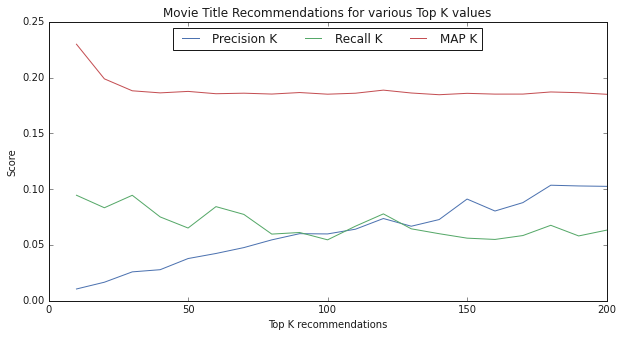

In [52]:
plt.plot(numRecommendations,pm_list,label='Precision K')
plt.plot(numRecommendations,rm_list,label='Recall K')
plt.plot(numRecommendations,mapkM_list,label='MAP K')


plt.xlabel('Top K recommendations')
plt.ylabel('Score')
plt.title('Movie Title Recommendations for various Top K values')
plt.legend(ncol=3,loc='upper center')
plt.savefig('outputs/title.png')

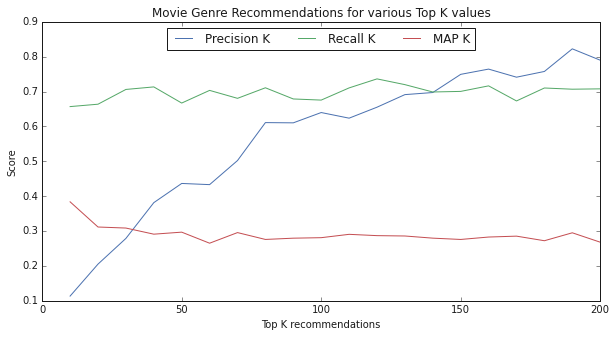

In [53]:
plt.plot(numRecommendations,pg_list,label='Precision K')
plt.plot(numRecommendations,rg_list,label='Recall K')
plt.plot(numRecommendations,mapkG_list,label='MAP K')

plt.xlabel('Top K recommendations')
plt.ylabel('Score')
plt.title('Movie Genre Recommendations for various Top K values')
plt.legend(ncol=3,loc='upper center')
plt.savefig('outputs/genre.png')

In [68]:
pm_list = []
rm_list = []
pg_list = []
rg_list = []
mapkM_list=[]
mapkG_list=[]

minRatings = list(range(0,5))

for rating in minRatings:
    t_pm_list = []
    t_rm_list = []
    t_pg_list = []
    t_rg_list = []
    t_mapkM_list=[]
    t_mapkG_list=[]
    for fold in range(3):
        pm,rm,mapkM,pg,rg,mapkG,len_test = evaluation(minRating=rating,test_split=0.2,numRecommendations=100)
        t_pm_list.append(np.mean(pm))
        t_rm_list.append(np.mean(rm))
        t_mapkM_list.append(np.mean(mapkM))

        t_pg_list.append(np.mean(pg))
        t_rg_list.append(np.mean(rg))
        t_mapkG_list.append(np.mean(mapkG))
    
    pm_list.append(np.mean(t_pm_list))
    rm_list.append(np.mean(t_rm_list))
    mapkM_list.append(np.mean(t_mapkM_list))

    pg_list.append(np.mean(t_pg_list))
    rg_list.append(np.mean(t_rg_list))
    mapkG_list.append(np.mean(t_mapkG_list))


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.40it/s]


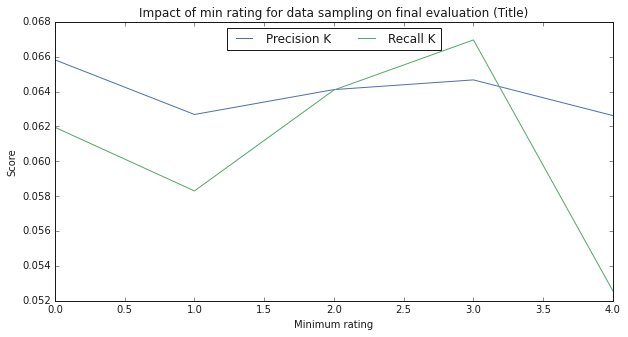

In [104]:
plt.plot(minRatings,pm_list,label='Precision K')
plt.plot(minRatings,rm_list,label='Recall K')
# plt.plot(minRatings,mapkM_list,label='MAP K')


plt.xlabel('Minimum rating')
plt.ylabel('Score')
plt.title('Impact of min rating for data sampling on final evaluation (Title)')
plt.legend(ncol=6,loc='upper center')
plt.savefig('outputs/ratingsTitle.png')

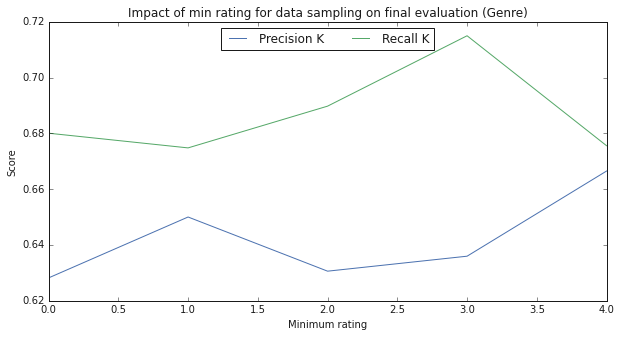

In [105]:


plt.plot(minRatings,pg_list,label='Precision K')
plt.plot(minRatings,rg_list,label='Recall K')
# plt.plot(minRatings,mapkG_list,label='MAP K')

plt.xlabel('Minimum rating')
plt.ylabel('Score')
plt.title('Impact of min rating for data sampling on final evaluation (Genre)')
plt.legend(ncol=6,loc='upper center')
plt.savefig('outputs/ratingsGenre.png')